### <center> Particle Filter Experiment for the Logistic Growth Model ###

In [262]:
import numpy as np
import matplotlib.pyplot as plt

from jax.experimental.ode import odeint
from scipy.stats import norm, poisson
from scipy.integrate import solve_ivp

import jax.numpy as jnp

# save all the plots in a pdf
from matplotlib.backends.backend_pdf import PdfPages

pp = PdfPages("logistic_dt_e10.pdf")

#### <center> Simulated Data

<Figure size 640x480 with 0 Axes>

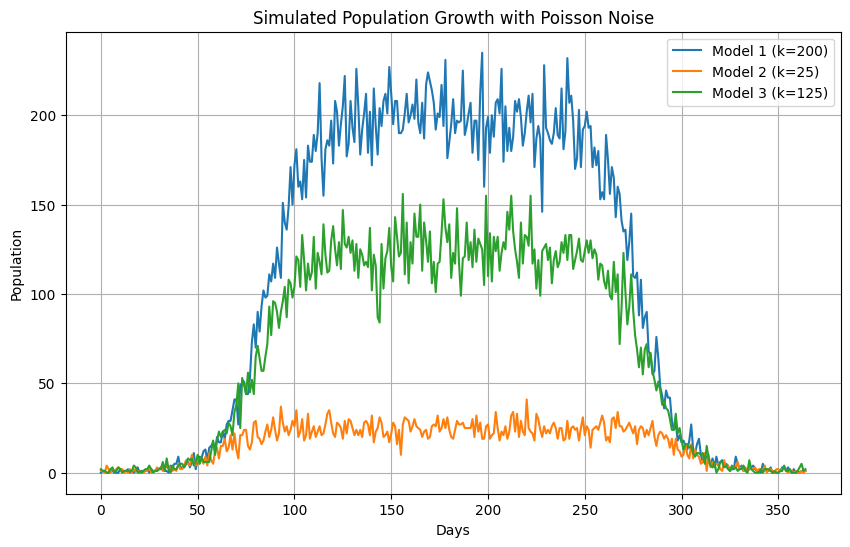

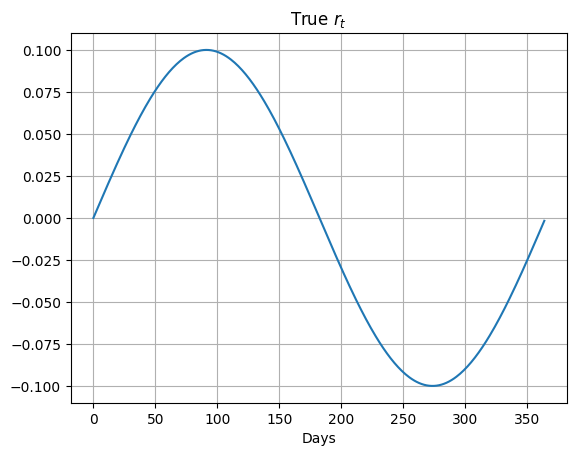

In [263]:
num_models = 3
rng = np.random.default_rng(20)
period = 365
d = 365
standard_deviation = 10


# r(t) is the growth rate of the population at time t
# max growth rate is 0.3 with time period of 365 days
def r_t(t):
    return 0.10 * jnp.sin(2 * jnp.pi * t / period)


def growthEQ(y, t, pars):
    r, k = pars
    return r(t) * y * (1 - (y / k))


# states is the initial population of the models
states = np.ones(num_models)


# k_vals is the carrying capacity of the population
# k_vals = np.array([rng.integers(10,50) for _ in range(num_models)])
k_vals = np.array([200, 25, 125])

# data is the population of the models at each time step
data = np.zeros((num_models, d))

# first dimension is the parameters with the first row being the growth rate and the second row being the carrying capacity
par = np.zeros((2, num_models, d))  # (num_parameters,num_models,len(time_series))

data[:, 0] = jnp.ones((num_models,))

data = odeint(
    func=lambda y, t: growthEQ(y, t, (r_t, k_vals)),
    y0=data[:, 0],
    t=jnp.linspace(0, d, d),
).T

# extract daily data
# add poisson noise to the data
data = rng.poisson(data)

# Create plot for data
fig = plt.figure()
plt.figure(figsize=(10, 6))
for i in range(num_models):
    plt.plot(np.arange(d), data[i, :], label=f"Model {i+1} (k={k_vals[i]})")


plt.title("Simulated Population Growth with Poisson Noise")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.show()
fig.savefig(pp, format="pdf")

fig = plt.figure()
plt.title("True $r_t$")
plt.xlabel("Days")
plt.grid(True)
plt.plot([r_t(t) for t in range(d)])
plt.show()
fig.savefig(pp, format="pdf")

#### <center> Particle Filter

In [264]:
# Setup the particle distribution

delta_t = 0.01
num_particles = 10000
# first dimension is the number of particles
# second dimension is the number of species
# third dimension is the state, r_t, and carrying capacity,
# fourth dimension is the number of days
log_particles = np.zeros((num_particles, num_models, 3, d))
log_weights = np.zeros((num_particles, d))

# initialize the particles
log_particles[:, :, 0, 0] = rng.uniform(
    0, 5, size=(num_particles, num_models)
)  # initializer for the state
log_particles[:, :, 1, 0] = rng.uniform(
    -0.5, 0.5, size=(num_particles, 1)
)  # initializer for r_t
log_particles[:, :, 2, 0] = rng.integers(
    10, 500, size=(num_particles, num_models)
)  # initializer for carrying capacity k


def growthEQ(y, t, par):
    return par[:, :, 0] * y * (1 - (y / par[:, :, 1]))

In [265]:
def jacobian(δ: np.ndarray):
    """
    The jacobian logarithm, used in log likelihood normalization and
    resampling processes.

    Args:
        δ: An array of values to sum

    Returns:
        The vector of partial sums of δ.
    """
    n = len(δ)
    Δ = np.zeros(n)
    Δ[0] = δ[0]
    for i in range(1, n):
        Δ[i] = max(δ[i], Δ[i - 1]) + np.log(1 + np.exp(-1 * np.abs(δ[i] - Δ[i - 1])))
    return Δ


def log_norm(log_weights):
    """
    Normalizes the probability space using the jacobian logarithm as
    defined in jacobian().
    """
    normalized = jacobian(log_weights)[-1]
    log_weights -= normalized
    return log_weights

In [266]:
# Running the particle filter
# OU process parameters, hyperparameters
OU_Params = {"theta": 0.05, "mean": 0.0, "diffusion": 0.05}

# h is the hyperparameter for the static paramter estimation
h = 0.1
a = np.sqrt(1 - h**2)

for time_index in range(d):  # Loop over the number of days in the data

    print(f"Iteration: {time_index} \r")

    ###Forecast
    if time_index > 0:

        # initialize with previous values
        log_particles[:, :, 0:2, time_index] = log_particles[:, :, 0:2, time_index - 1]

        for _ in range(int(1 / delta_t)):

            # Forward Euler integration
            log_particles[:, :, 0, time_index] = log_particles[
                :, :, 0, time_index
            ] + delta_t * growthEQ(
                log_particles[:, :, 0, time_index],
                time_index,
                log_particles[:, :, 1:, time_index - 1],
            )

            # Need the weiner process fixed for rng
            dW = rng.normal(0, scale=np.sqrt(delta_t), size=(num_particles))

            log_particles[:, :, 1, time_index] = (
                log_particles[:, 0, 1, time_index]
                + OU_Params["theta"]
                * (OU_Params["mean"] - log_particles[:, 0, 1, time_index])
                * delta_t
                + OU_Params["diffusion"] * dW
            ).reshape((num_particles, 1))

        """Log domain static parameter computation"""
        num_statics = log_particles[:, :, 2, time_index - 1].shape[1]

        deltas = np.zeros((num_particles, num_statics))

        """Now compute the deltas, we must log each parameter """
        for i in range(num_statics):
            sub_theta = np.log(log_particles[:, i, 2, time_index - 1])
            """sub_theta shape is (particle_count,1)"""

            for j in range(num_particles):
                log_theta = sub_theta[j]
                log_log = np.log(np.abs(log_theta))
                """Absolute value here accounts for taking log of a negative number, 
                log_theta is surely negative. We take the complex part outside the computation. """

                """Make sure to add the weights to the deltas. Must be the log weights for this to work properly. """
                deltas[j, i] = log_weights[j, time_index - 1] + log_log

        ξ = []
        for i in range(num_statics):
            """Compute ξ elementwise and multiply by -1 to account for the sign change."""
            ξ.append(np.exp(jacobian(deltas[:, i])))

        """Need to pull the last element, remember jacob returns the array of partial sums. """
        ξ = np.array(ξ)[:, -1]

        psis = np.array(np.log(log_particles[:, :, 2, time_index - 1]) - ξ)

        matrix_set = []
        for i in range(num_particles):
            matrix_set.append(np.outer(psis[i, :], psis[i, :]))
        matrix_set = np.array(matrix_set)

        Σ = np.zeros((num_statics, num_statics))

        C = 100

        for i in range(num_statics):
            for j in range(num_statics):
                if i != j:

                    deltas_Y = (
                        np.log(
                            matrix_set[:, i, j] + C * np.ones_like(matrix_set[:, i, j])
                        )
                        + log_weights[:, time_index - 1]
                    )

                    deltas_Z = log_weights[:, time_index - 1] + np.log(
                        C * np.ones_like(log_weights[:, time_index - 1])
                    )

                    Z = np.exp(jacobian(deltas_Z)[-1])

                    Σ[i, j] = np.exp(jacobian(deltas_Y)[-1]) - Z

                else:
                    """On the diagonal the elements are guaranteed to be positive, so there isn't a"""

                    deltas = (
                        np.log(matrix_set[:, i, j]) + log_weights[:, time_index - 1]
                    )
                    Σ[i, j] = np.exp(jacobian(deltas)[-1])

        """Static parameter perturbation"""
        for p in range(num_particles):

            standard_variates = rng.standard_normal((num_models,)).reshape(
                -1, num_models
            )

            (u, s, v) = np.linalg.svd((h**2) * Σ)

            log_samples = np.dot(standard_variates, np.sqrt(s)[:, None] * v)
            log_samples += (
                a * np.log(log_particles[p, :, 2, time_index - 1]) + (1 - a) * ξ
            )
            log_particles[p, :, 2, time_index] = np.exp(log_samples)

    """Resampling"""
    for model in range(num_models):
        log_weights[:, time_index] += norm.logpdf(
            data[model, time_index],
            log_particles[:, model, 0, time_index],
            scale=standard_deviation,
        )

    # Normalize the weights
    log_weights[:, time_index] = log_norm(log_weights[:, time_index])

    # setup the resampling indices
    resampling_indices_log = np.zeros(num_particles, dtype=int)
    cdf_log = jacobian(log_weights[:, time_index])

    u = rng.uniform(0, 1 / num_particles)

    """Log resample"""
    i = 0
    for j in range(num_particles):
        r_log = np.log(u + (1 / num_particles) * j)
        while r_log > cdf_log[i]:
            i += 1
        resampling_indices_log[j] = i

    """Reindexing the array"""
    log_particles_copy = log_particles[:, :, :, time_index].copy()
    log_particles[:, :, :, time_index] = log_particles_copy[
        resampling_indices_log, :, :
    ]

Iteration: 0 
Iteration: 1 
Iteration: 2 
Iteration: 3 
Iteration: 4 
Iteration: 5 
Iteration: 6 
Iteration: 7 
Iteration: 8 
Iteration: 9 
Iteration: 10 
Iteration: 11 
Iteration: 12 
Iteration: 13 
Iteration: 14 
Iteration: 15 
Iteration: 16 
Iteration: 17 
Iteration: 18 
Iteration: 19 
Iteration: 20 
Iteration: 21 
Iteration: 22 
Iteration: 23 
Iteration: 24 
Iteration: 25 
Iteration: 26 
Iteration: 27 
Iteration: 28 
Iteration: 29 
Iteration: 30 
Iteration: 31 
Iteration: 32 
Iteration: 33 
Iteration: 34 
Iteration: 35 
Iteration: 36 
Iteration: 37 
Iteration: 38 
Iteration: 39 
Iteration: 40 
Iteration: 41 
Iteration: 42 
Iteration: 43 
Iteration: 44 
Iteration: 45 
Iteration: 46 
Iteration: 47 
Iteration: 48 
Iteration: 49 
Iteration: 50 
Iteration: 51 
Iteration: 52 
Iteration: 53 
Iteration: 54 
Iteration: 55 
Iteration: 56 
Iteration: 57 
Iteration: 58 
Iteration: 59 
Iteration: 60 
Iteration: 61 
Iteration: 62 
Iteration: 63 
Iteration: 64 
Iteration: 65 
Iteration: 66 
Itera

In [267]:
print(log_weights[:, time_index])

[-9.20289306 -9.20272023 -9.18459182 ... -9.20873603 -9.20704478
 -9.20864423]


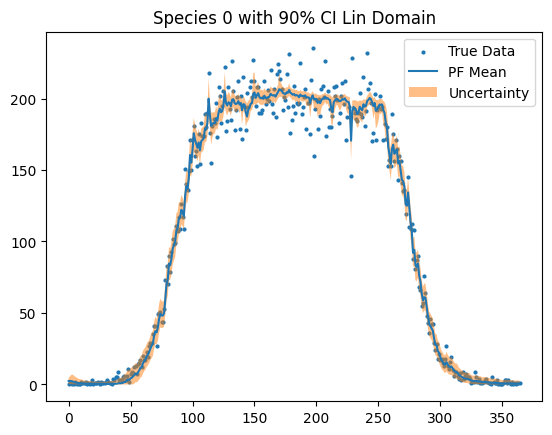

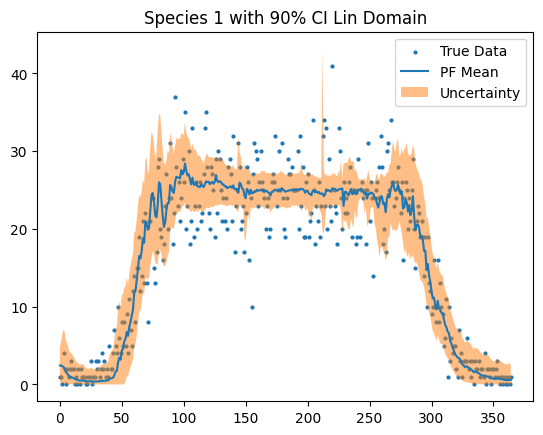

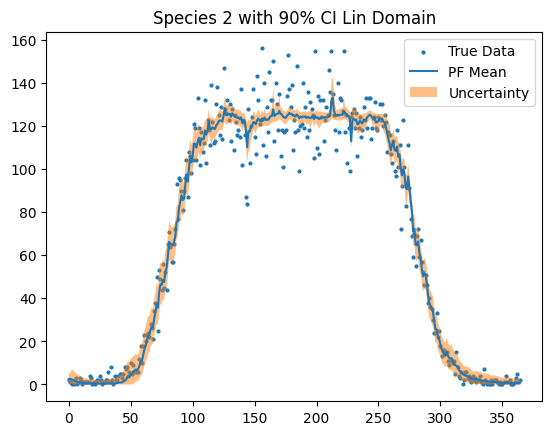

In [268]:
for model in range(num_models):
    fig = plt.figure()
    # plot the true data in scatter plot with a smaller size
    plt.scatter(np.arange(d), data[model, :], s=4)
    # plot the mean, and make the line thinner
    plt.plot(np.average(lin_particles[:, model, 0, :], weights=lin_weights, axis=0))
    # plot the uncertainty
    plt.fill_between(
        np.arange(d),
        np.percentile(lin_particles[:, model, 0, :], 5, axis=0),
        np.percentile(lin_particles[:, model, 0, :], 95, axis=0),
        alpha=0.5,
    )
    # add a title
    plt.title(f"Species {model} " + "with 90% CI Lin Domain")
    # add a legend to the top right
    plt.legend(["True Data", "PF Mean", "Uncertainty"], loc="upper right")
    plt.show()
    fig.savefig(pp, format="pdf")

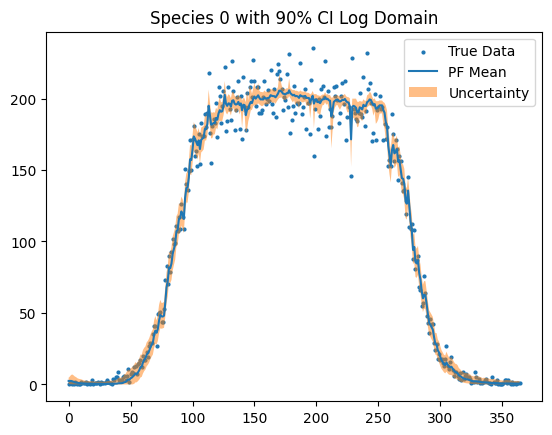

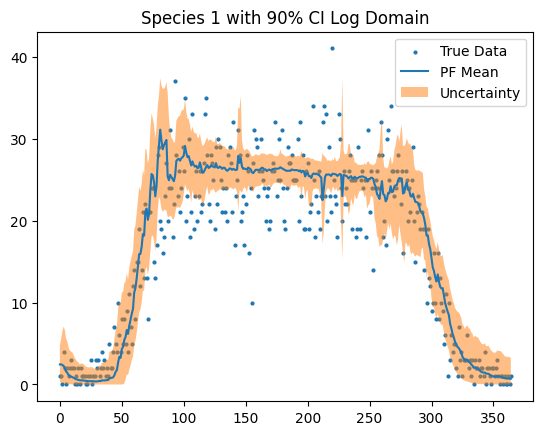

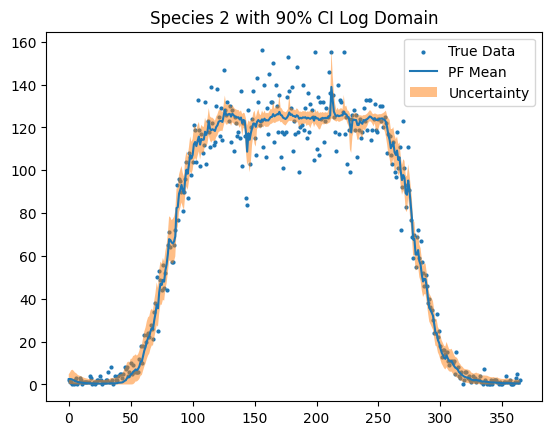

In [269]:
for model in range(num_models):
    fig = plt.figure()
    # plot the true data in scatter plot with a smaller size
    plt.scatter(np.arange(d), data[model, :], s=4)
    # plot the mean, and make the line thinner
    plt.plot(np.average(log_particles[:, model, 0, :], weights=log_weights, axis=0))
    # plot the uncertainty
    plt.fill_between(
        np.arange(d),
        np.percentile(log_particles[:, model, 0, :], 5, axis=0),
        np.percentile(log_particles[:, model, 0, :], 95, axis=0),
        alpha=0.5,
    )
    # add a title
    plt.title(f"Species {model} " + "with 90% CI Log Domain")
    # add a legend to the top right
    plt.legend(["True Data", "PF Mean", "Uncertainty"], loc="upper right")
    plt.show()
    fig.savefig(pp, format="pdf")

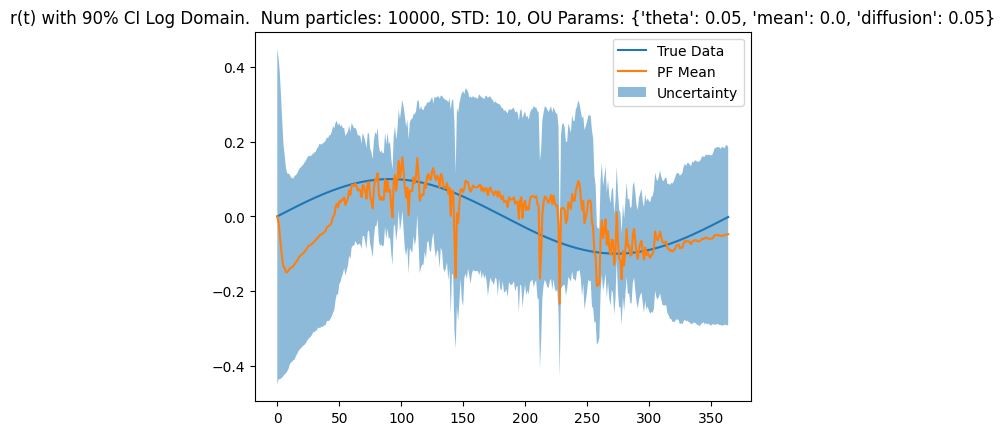

In [270]:
fig = plt.figure()
plt.plot([r_t(t) for t in range(d)])
plt.plot(np.average(log_particles[:, model, 1, :], weights=log_weights, axis=0))
# plot the uncertainty
plt.fill_between(
    np.arange(d),
    np.percentile(log_particles[:, 0, 1, :], 5, axis=0),
    np.percentile(log_particles[:, 0, 1, :], 95, axis=0),
    alpha=0.5,
)
# add a title
plt.title(
    f"r(t) with 90% CI Log Domain.  Num particles: {num_particles}, STD: {standard_deviation}, OU Params: {OU_Params}"
)
# add a legend to the top right
plt.legend(["True Data", "PF Mean", "Uncertainty"], loc="upper right")
plt.show()
fig.savefig(pp, format="pdf")

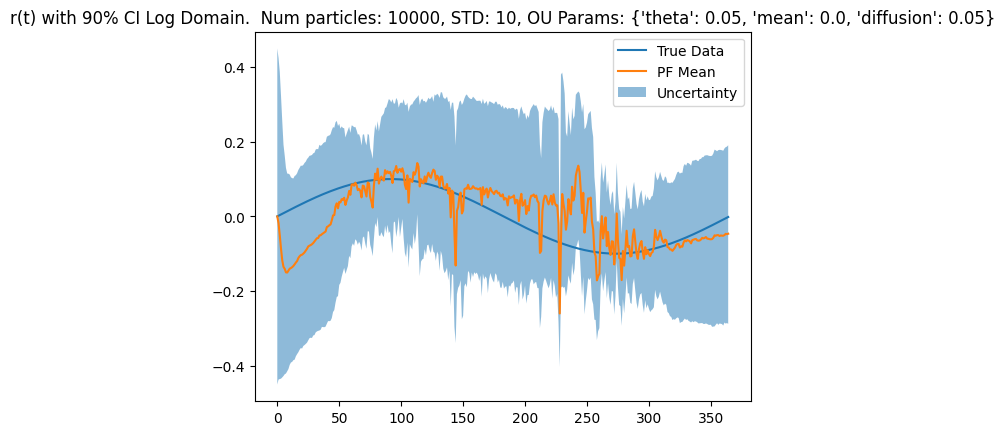

In [271]:
fig = plt.figure()
plt.plot([r_t(t) for t in range(d)])
plt.plot(np.average(lin_particles[:, 0, 1, :], weights=lin_weights, axis=0))
# plot the uncertainty
plt.fill_between(
    np.arange(d),
    np.percentile(lin_particles[:, 0, 1, :], 5, axis=0),
    np.percentile(lin_particles[:, 0, 1, :], 95, axis=0),
    alpha=0.5,
)
# add a title
plt.title(
    f"r(t) with 90% CI Log Domain.  Num particles: {num_particles}, STD: {standard_deviation}, OU Params: {OU_Params}"
)
# add a legend to the top right
plt.legend(["True Data", "PF Mean", "Uncertainty"], loc="upper right")
plt.show()
fig.savefig(pp, format="pdf")

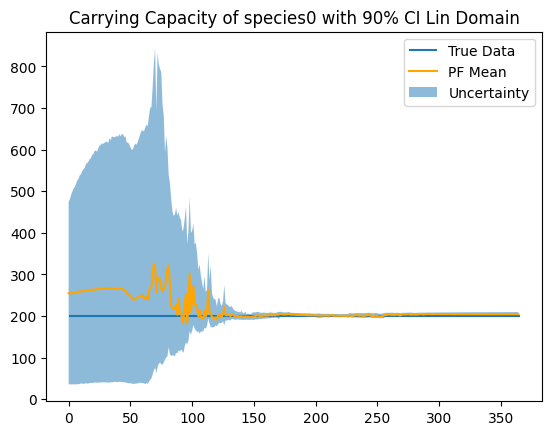

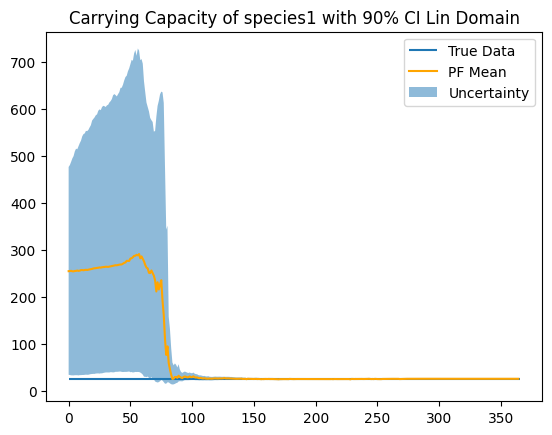

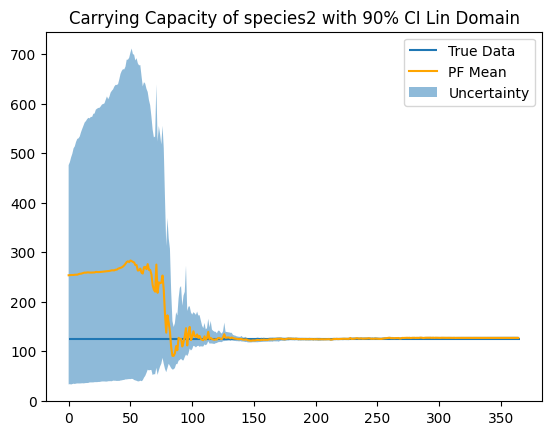

In [272]:
for model in range(num_models):
    fig = plt.figure()
    plt.hlines(k_vals[model], xmin=0, xmax=d)
    plt.plot(
        np.average(lin_particles[:, model, 2, :], weights=lin_weights, axis=0),
        color="orange",
    )
    # plot the uncertainty
    plt.fill_between(
        np.arange(d),
        np.percentile(lin_particles[:, model, 2, :], 5, axis=0),
        np.percentile(lin_particles[:, model, 2, :], 95, axis=0),
        alpha=0.5,
    )
    # add a title
    plt.title("Carrying Capacity of species" + str(model) + " with 90% CI Lin Domain")
    # add a legend to the top right
    plt.legend(["True Data", "PF Mean", "Uncertainty"], loc="upper right")
    plt.show()
    fig.savefig(pp, format="pdf")

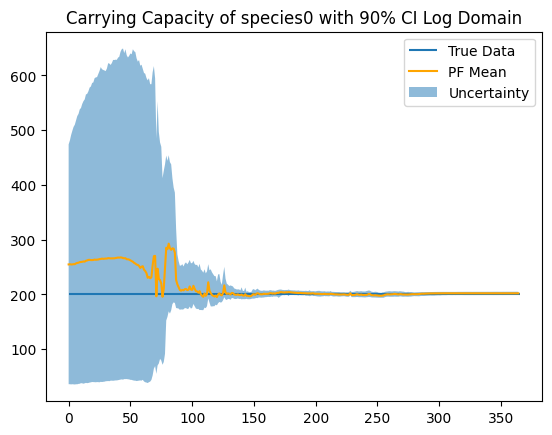

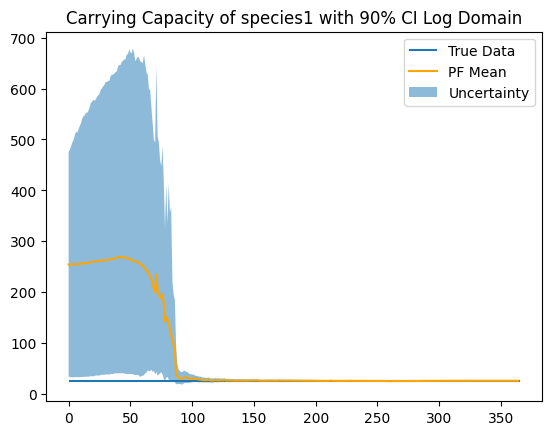

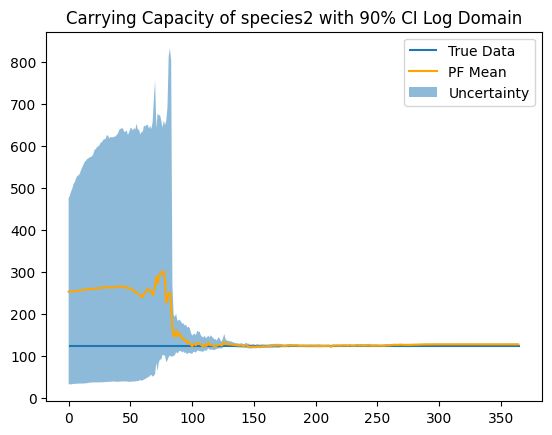

In [273]:
for model in range(num_models):
    fig = plt.figure()
    plt.hlines(k_vals[model], xmin=0, xmax=d)
    plt.plot(
        np.average(log_particles[:, model, 2, :], weights=log_weights, axis=0),
        color="orange",
    )
    # plot the uncertainty
    plt.fill_between(
        np.arange(d),
        np.percentile(log_particles[:, model, 2, :], 5, axis=0),
        np.percentile(log_particles[:, model, 2, :], 95, axis=0),
        alpha=0.5,
    )
    # add a title
    plt.title("Carrying Capacity of species" + str(model) + " with 90% CI Log Domain")
    # add a legend to the top right
    plt.legend(["True Data", "PF Mean", "Uncertainty"], loc="upper right")
    plt.show()
    fig.savefig(pp, format="pdf")

-3.3098180170563847


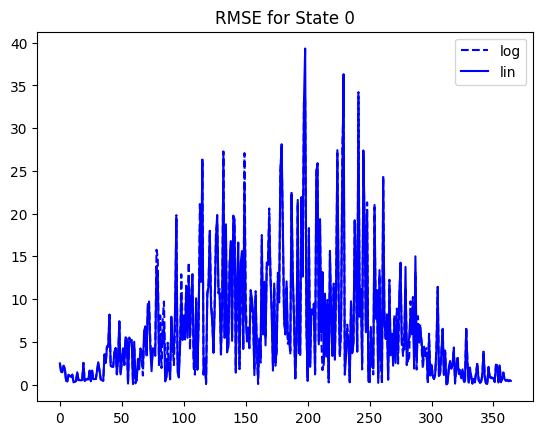

84.55001132911752


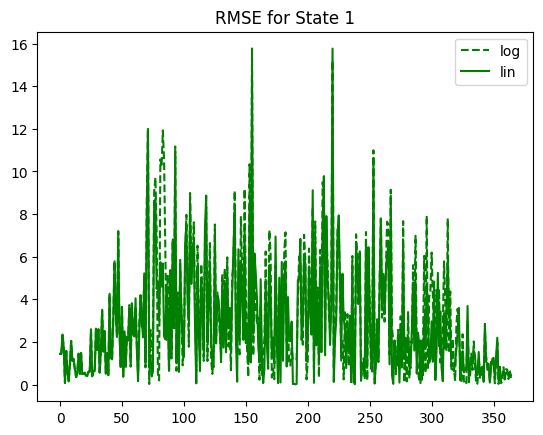

-58.646411286119644


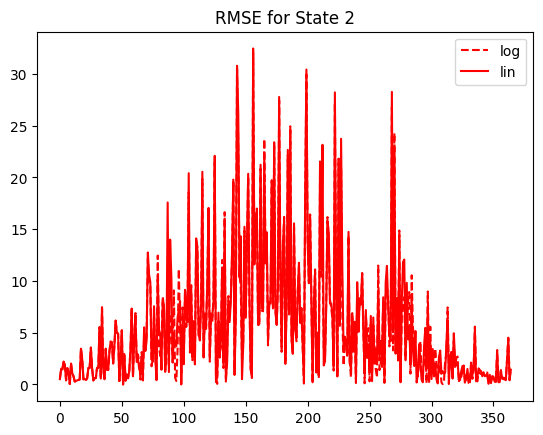

In [274]:
###Root Mean Square Error
colors = ["b", "g", "r", "c", "m", "y", "k", "w", "b", "g"]

# compute rsme for each location across time t
rmse_lin = np.zeros((d, num_models))
rmse_log = np.zeros((d, num_models))

for loc in range(num_models):
    rmse_log[:, loc] = np.sqrt(
        (
            np.average(log_particles[:, loc, 0, :], weights=np.exp(log_weights), axis=0)
            - data[loc, :]
        )
        ** 2
    )
    rmse_lin[:, loc] = np.sqrt(
        (
            np.average(lin_particles[:, loc, 0, :], weights=lin_weights, axis=0)
            - data[loc, :]
        )
        ** 2
    )
    # print(f"Location {loc} Time {t} RMSE log: {rmse_log} RMSE lin: {rmse_lin}")

# plot the rmse across time for each location in one figure
for loc in range(num_models):
    plt.title(f"RMSE for State {loc}")
    plt.plot(rmse_log[:, loc], "--", label="log", color=colors[loc])
    plt.plot(rmse_lin[:, loc], label="lin", color=colors[loc])
    plt.legend()
    print(np.sum(rmse_log[:, loc] - rmse_lin[:, loc]))
    plt.show()

0.6544889849788327


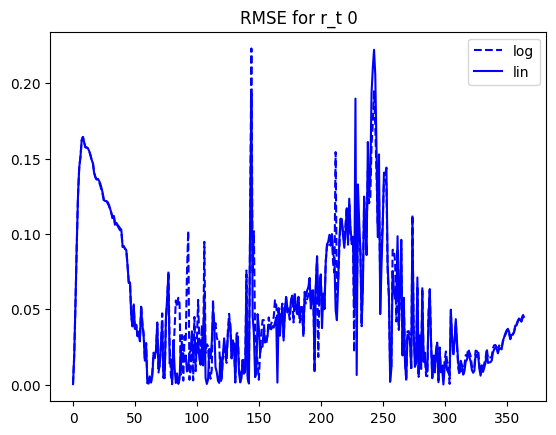

0.6544889849788327


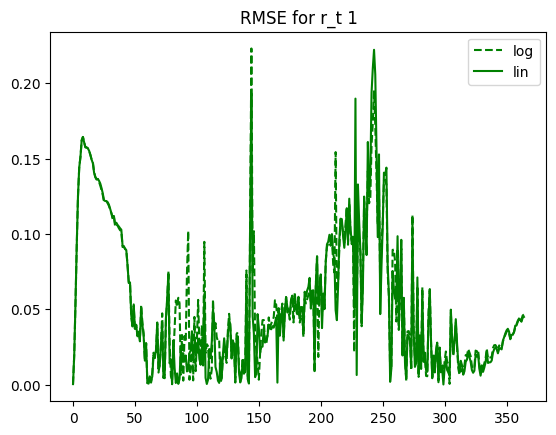

0.6544889849788327


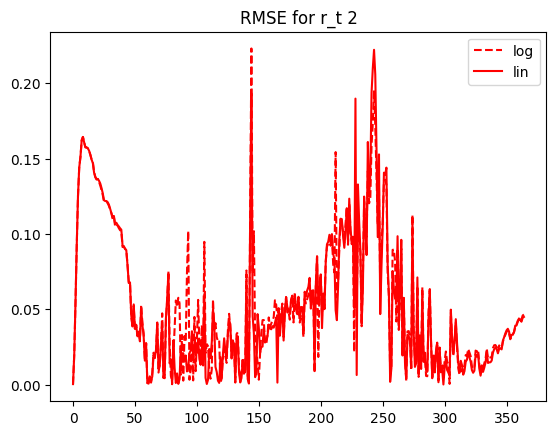

In [275]:
###Root Mean Square Error
colors = ["b", "g", "r", "c", "m", "y", "k", "w", "b", "g"]

# compute rsme for each location across time t
rmse_lin = np.zeros((d, num_models))
rmse_log = np.zeros((d, num_models))

real = [r_t(t) for t in range(d)]

for loc in range(num_models):
    rmse_log[:, loc] = np.sqrt(
        (
            np.average(log_particles[:, loc, 1, :], weights=np.exp(log_weights), axis=0)
            - real
        )
        ** 2
    )
    rmse_lin[:, loc] = np.sqrt(
        (np.average(lin_particles[:, loc, 1, :], weights=lin_weights, axis=0) - real)
        ** 2
    )
    # print(f"Location {loc} Time {t} RMSE log: {rmse_log} RMSE lin: {rmse_lin}")

# plot the rmse across time for each location in one figure
for loc in range(num_models):
    plt.title(f"RMSE for r_t {loc}")
    plt.plot(rmse_log[:, loc], "--", label="log", color=colors[loc])
    plt.plot(rmse_lin[:, loc], label="lin", color=colors[loc])
    plt.legend()
    print(np.sum(rmse_log[:, loc] - rmse_lin[:, loc]))
    plt.show()

-1056.8463868181814


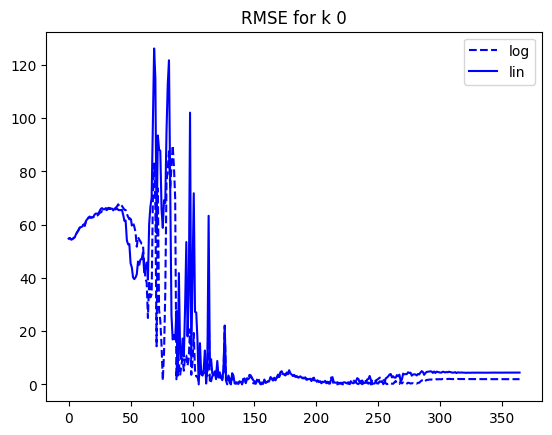

23.198539109105653


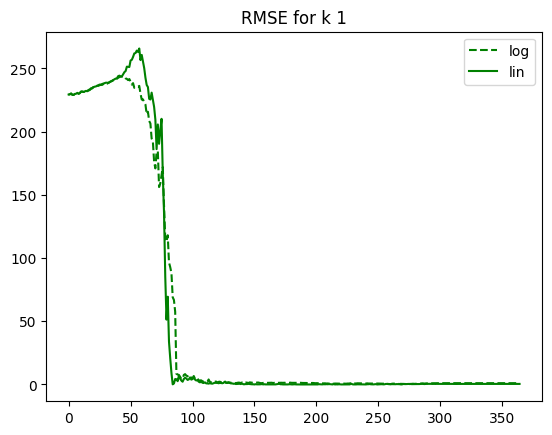

631.7113245093248


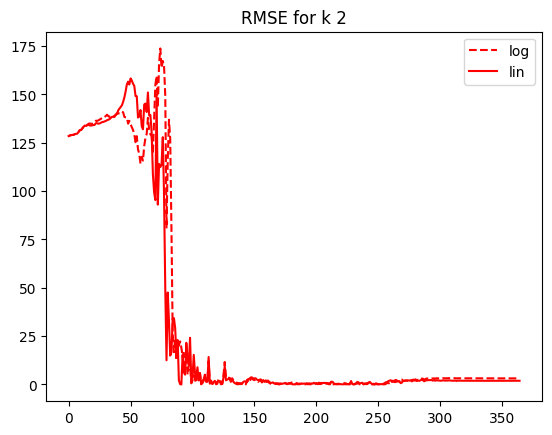

In [276]:
###Root Mean Square Error
colors = ["b", "g", "r", "c", "m", "y", "k", "w", "b", "g"]

# compute rsme for each location across time t
rmse_lin = np.zeros((d, num_models))
rmse_log = np.zeros((d, num_models))

for loc in range(num_models):
    rmse_log[:, loc] = np.sqrt(
        (
            np.average(log_particles[:, loc, 2, :], weights=np.exp(log_weights), axis=0)
            - k_vals[loc]
        )
        ** 2
    )
    rmse_lin[:, loc] = np.sqrt(
        (
            np.average(lin_particles[:, loc, 2, :], weights=lin_weights, axis=0)
            - k_vals[loc]
        )
        ** 2
    )
    # print(f"Location {loc} Time {t} RMSE log: {rmse_log} RMSE lin: {rmse_lin}")

# plot the rmse across time for each location in one figure
for loc in range(num_models):
    plt.title(f"RMSE for k {loc}")
    plt.plot(rmse_log[:, loc], "--", label="log", color=colors[loc])
    plt.plot(rmse_lin[:, loc], label="lin", color=colors[loc])
    plt.legend()
    print(np.sum(rmse_log[:, loc] - rmse_lin[:, loc]))
    plt.show()

In [277]:
pp.close()